In [1]:
import torch

In [2]:
from torchvision import models

Let's load a ResNet18 model so as to more easily consult a few of its attributes that are used in the definition of `FCNResnet18` below.

In [3]:
try:
    resnet18 = models.ResNet()
    print(f"resnet18 =\n{resnet18}")
except Exception as e:
    print(e)

__init__() missing 2 required positional arguments: 'block' and 'layers'


In [4]:
resnet18 = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2])

In [5]:
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [6]:
resnet18.fc.weight.shape, resnet18.fc.bias.shape

(torch.Size([1000, 512]), torch.Size([1000]))

In [7]:
resnet18.fc.weight.data.shape, resnet18.fc.bias.data.shape

(torch.Size([1000, 512]), torch.Size([1000]))

In [8]:
from torch.hub import load_state_dict_from_url

class FCNResnet18(models.ResNet):
    def __init__(self, num_classes=1000, pretrained=False, **kwargs):
        # https://github.com/pytorch/vision/blob/b2e95657cd5f389e3973212ba7ddbdcc751a7878/torchvision/models/resnet.py
        super().__init__(
            block=models.resnet.BasicBlock,
            layers=[2, 2, 2, 2],
            num_classes=num_classes,
            **kwargs
        )
        if pretrained:
            state_dict = load_state_dict_from_url(models.resnet.model_urls["resnet18"], progress=True)
            self.load_state_dict(state_dict)

        # Replace AdaptiveAvgPool2d with standard AvgPool2d
        # https://github.com/pytorch/vision/blob/b2e95657cd5f389e3973212ba7ddbdcc751a7878/torchvision/models/resnet.py#L153-L154
        self.avgpool = torch.nn.AvgPool2d((7, 7))

        self.last_conv = torch.nn.Conv2d(
            in_channels=self.fc.in_features,
            out_channels=num_classes,
            kernel_size=1,
        )
        self.last_conv.weight.data.copy_(self.fc.weight.data.view(*self.fc.weight.data.shape, 1, 1))
        self.last_conv.bias.data.copy_(self.fc.bias.data)

    # https://github.com/pytorch/vision/blob/b2e95657cd5f389e3973212ba7ddbdcc751a7878/torchvision/models/resnet.py#L197-L213
    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        x = self.last_conv(x)
        return x

**(?)** I remember PyTorch models usually have the `forward()` method; why here we do not implement `forward()`? Why `_forward_impl()`?

In [9]:
model = FCNResnet18(pretrained=True).eval()

In [10]:
model.last_conv.weight.shape, model.last_conv.weight.data.shape

(torch.Size([1000, 512, 1, 1]), torch.Size([1000, 512, 1, 1]))

Recall that `torch` is _**channel-first**_, so the shape `[1000, 512, 1, 1]` means that there are 1000 kernels, each of shape `[512, 1, 1]`.

In [11]:
model.last_conv.bias.shape, model.last_conv.bias.data.shape

(torch.Size([1000]), torch.Size([1000]))

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

DARK_READER = True
if DARK_READER:
    plt.rcParams.update({
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "black",
        "axes.facecolor": "black",
        "axes.edgecolor": "lightgray",
        "axes.labelcolor": "white",
        "axes.titlecolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "lightgray",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black",
    })

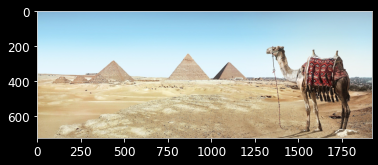

In [13]:
import cv2

# One can switch to otter.jpg or any other images one has,
# just be aware that the Markdown comments below won't be
# precise any more if one switches to any image other than camel.jpg
# Otherwise, everything should work just fine.

original_image = cv2.imread("camel.jpg")
#original_image = cv2.imread("otter.jpg")
image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

Invalid shape (3, 725, 1920) for image data


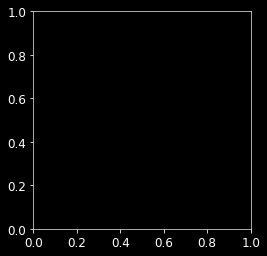

In [14]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])
image = transform(image)

try:
    plt.imshow(image.numpy());
except Exception as e:
    print(e)

In [15]:
image.numpy().shape

(3, 725, 1920)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


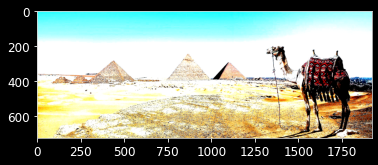

In [16]:
import numpy as np
plt.imshow(np.transpose(image, (1, 2, 0)));

**(?)** Must all images go thru this kind of transforms or it's also fine to not use these transforms?

In [17]:
image.max(), image.min()

(tensor(2.6400), tensor(-2.1179))

In [18]:
image = image.unsqueeze(0)  # add batch size = 1
image.shape

torch.Size([1, 3, 725, 1920])

In [19]:
with torch.no_grad():
    preds = model(image)
    print(preds.shape)

torch.Size([1, 1000, 3, 8])


[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


In [20]:
preds

tensor([[[[ 0.0196,  0.5244,  0.4816,  ...,  0.2265,  0.0962, -0.1254],
          [-2.8818, -3.4244, -0.8499,  ..., -1.6626, -1.1515, -0.5238],
          [-1.8039, -0.9490, -1.4343,  ..., -1.6382, -2.4623, -3.9720]],

         [[-1.0249, -0.8879, -0.7674,  ..., -1.2588, -2.2617, -1.6142],
          [-3.3864, -4.3541, -2.1928,  ..., -4.0444, -4.1827, -2.9018],
          [-0.4087, -0.1353, -1.0594,  ..., -2.0745, -1.8864, -4.2119]],

         [[ 0.1973, -0.1640, -0.1680,  ...,  0.1185,  0.3005,  0.5347],
          [-0.9632, -1.0242,  1.3085,  ..., -0.4826,  2.7034,  3.4011],
          [-0.2108,  0.9883,  0.1864,  ..., -0.2522,  0.6723,  1.1368]],

         ...,

         [[-1.8420, -1.4882, -1.4675,  ..., -1.6463, -1.7198, -1.4125],
          [-1.5470, -2.0611, -0.3574,  ..., -2.8694, -1.3751, -0.5972],
          [-0.3385, -0.2173, -1.6557,  ..., -1.8689, -2.2067, -4.3884]],

         [[ 1.2787,  0.9536,  0.9574,  ...,  0.9273,  0.7524,  0.1959],
          [ 0.0789, -1.1222,  0.0839,  ..

In [21]:
with torch.no_grad():
    preds = model(image)
    preds = torch.softmax(preds, dim=1)
    print(preds.shape)

torch.Size([1, 1000, 3, 8])


In [22]:
preds

tensor([[[[3.8187e-04, 6.8149e-04, 6.2108e-04,  ..., 5.5313e-04,
           4.9801e-04, 4.0048e-04],
          [6.7416e-07, 1.0051e-06, 2.9551e-05,  ..., 2.7202e-05,
           5.4968e-06, 5.2088e-06],
          [6.9844e-05, 3.9973e-05, 6.1009e-05,  ..., 5.2115e-05,
           1.2121e-05, 6.4579e-08]],

         [[1.3436e-04, 1.6600e-04, 1.7812e-04,  ..., 1.2524e-04,
           4.7124e-05, 9.0362e-05],
          [4.0704e-07, 3.9666e-07, 7.7159e-06,  ..., 2.5130e-06,
           2.6527e-07, 4.8305e-07],
          [2.8189e-04, 9.0183e-05, 8.8754e-05,  ..., 3.3689e-05,
           2.1560e-05, 5.0802e-08]],

         [[4.5613e-04, 3.4237e-04, 3.2436e-04,  ..., 4.9650e-04,
           6.1089e-04, 7.7490e-04],
          [4.5919e-06, 1.1081e-05, 2.5584e-04,  ..., 8.8524e-05,
           2.5958e-04, 2.6382e-04],
          [3.4356e-04, 2.7740e-04, 3.0847e-04,  ..., 2.0839e-04,
           2.7854e-04, 1.0685e-05]],

         ...,

         [[5.9353e-05, 9.1072e-05, 8.8443e-05,  ..., 8.5005e-05,
     

In [23]:
preds.sum(axis=1)

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]])

In [24]:
_.shape

torch.Size([1, 3, 8])

In [25]:
preds.shape

torch.Size([1, 1000, 3, 8])

In [26]:
pred, class_idx = torch.max(preds, dim=1)
pred, class_idx

(tensor([[[0.0511, 0.0384, 0.0367, 0.0304, 0.0279, 0.0307, 0.0296, 0.0194],
          [0.5009, 0.1650, 0.1246, 0.1362, 0.1477, 0.0673, 0.8685, 0.3385],
          [0.0863, 0.1204, 0.0786, 0.2635, 0.1026, 0.1137, 0.2548, 0.7218]]]),
 tensor([[[977, 977, 977, 977, 977, 978, 354, 437],
          [978, 977, 980, 977, 858, 970, 354, 461],
          [977, 978, 977, 977, 977, 977, 354, 354]]]))

In [27]:
pred.shape, class_idx.shape

(torch.Size([1, 3, 8]), torch.Size([1, 3, 8]))

In [28]:
np.squeeze(np.unique(class_idx.numpy()))

array([354, 437, 461, 858, 970, 977, 978, 980])

What are these predictions' corresponding labels (in English)? We have the correspondance stored in the file `imagenet_classes.txt`

In [29]:
with open("imagenet_classes.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
labels[:5]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

In [30]:
[labels[k] for k in np.squeeze(np.unique(class_idx.numpy()))]

['Arabian camel, dromedary, Camelus dromedarius',
 'beacon, lighthouse, beacon light, pharos',
 'breastplate, aegis, egis',
 'tile roof',
 'alp',
 'sandbar, sand bar',
 'seashore, coast, seacoast, sea-coast',
 'volcano']

For `camel.jpg` only the option `"camel"` is realistic.

In [31]:
pred.shape

torch.Size([1, 3, 8])

In [32]:
row_max, row_idx = torch.max(pred, dim=1)
row_max, row_idx

(tensor([[0.5009, 0.1650, 0.1246, 0.2635, 0.1477, 0.1137, 0.8685, 0.7218]]),
 tensor([[1, 1, 1, 2, 1, 2, 1, 2]]))

In [33]:
row_max.shape, row_idx.shape

(torch.Size([1, 8]), torch.Size([1, 8]))

In [34]:
col_max, col_idx = torch.max(row_max, dim=1)
col_max, col_idx

(tensor([0.8685]), tensor([6]))

In [35]:
pred_class_id = class_idx[0, row_idx[0, col_idx], col_idx]
pred_class = labels[pred_class_id]
pred_class_id, pred_class

(tensor([354]), 'Arabian camel, dromedary, Camelus dromedarius')

> The result can be interpreted as the inference performed on 3 x 8 = 24 locations on the image obtained by sliding window of size 224×224 ( the input image size for the original network ).

**(?)** Why `224x224`?

In [36]:
score_map = preds[0, pred_class_id, :, :].cpu().numpy()
score_map.shape

(1, 3, 8)

The above shape is `(1,4,7)` instead of `(4,7)` because pred_class_id equals `tensor([360])`

In [37]:
score_map = score_map[0]

In [38]:
original_image.shape

(725, 1920, 3)

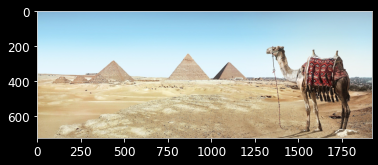

In [39]:
plt.imshow(original_image[...,::-1]);

In [40]:
h, w = original_image.shape[:2]
score_map = cv2.resize(score_map, (w, h))
score_map.shape

(725, 1920)

In [41]:
score_map.max(), score_map.min()

(0.86675256, 0.0018094395)

In [42]:
_, score_map_for_contours = cv2.threshold(
    score_map,
    0.25,
    1,
    type=cv2.THRESH_BINARY,
)

#### Threshold Binary
This thresholding operation can be expressed as:

$$\texttt{dst} (x,y) = \fork{\texttt{maxVal}}{if \texttt{src}(x,y) > \texttt{thresh}}{0}{otherwise}
$$

So, if the intensity of the pixel $src(x,y)$ is higher than $thresh$, then the new pixel intensity is set to a $MaxVal$. Otherwise, the pixels are set to $0$.

In [44]:
score_map_for_contours.dtype, score_map_for_contours.shape

(dtype('float32'), (725, 1920))

In [45]:
score_map_for_contours[:10, -10:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [46]:
score_map_for_contours[700:710, 1900:1910]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

In [47]:
np.unique(score_map_for_contours)

array([0., 1.], dtype=float32)

In [48]:
# Don't need to copy()
#score_map_for_contours = score_map_for_contours.astype(np.uint8).copy()
score_map_for_contours = score_map_for_contours.astype(np.uint8)

In [49]:
score_map_for_contours.shape

(725, 1920)

In [50]:
contours, _ = cv2.findContours(
    score_map_for_contours,
    mode=cv2.RETR_EXTERNAL,
    method=cv2.CHAIN_APPROX_SIMPLE,
)
contours

[array([[[1559,  184]],
 
        [[1558,  185]],
 
        [[1556,  185]],
 
        ...,
 
        [[1563,  185]],
 
        [[1561,  185]],
 
        [[1560,  184]]], dtype=int32)]

In [51]:
len(contours)

1

In [52]:
contours[0].shape

(549, 1, 2)

In [53]:
rect = cv2.boundingRect(contours[0])
rect

(1379, 184, 541, 541)

In [54]:
score_map[:].shape

(725, 1920)

In [55]:
# Apply score map as a mask to original image
score_map = score_map - np.min(score_map[:])
score_map = score_map / np.max(score_map[:])

The previous cell carries the entries of `score_map` all to the range of $[0, 1]$

In [56]:
score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2BGR)
score_map.shape

(725, 1920, 3)

In [57]:
np.array_equal(score_map[...,0], score_map[...,1])

True

In [58]:
np.array_equal(score_map[...,0], score_map[...,2])

True

In [59]:
masked_image = (original_image * score_map).astype(np.uint8)

In [60]:
def imshowBGR(ndarray):
    plt.imshow(ndarray[...,::-1]);

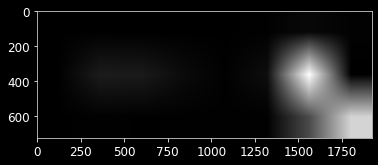

In [61]:
imshowBGR(score_map)

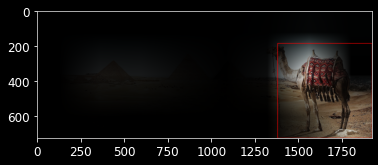

In [62]:
# Display bbox
red = (0,0,255)
cv2.rectangle(
    masked_image,
    rect[:2],
    (rect[0] + rect[2], rect[1] + rect[3]),
    red,
    2,
)
imshowBGR(masked_image)

**(?)** Why does this work? It's somewhat like attention.<br>
**(R)** Recall that we first defined

```python
score_map = preds[0, pred_class_id, :, :].cpu().numpy()
```
This is like picking the highest-score sliding window. Then the following code resizes `score_map` to make it equally wide and equally hight as the original image

```python
h, w = original_image.shape[:2]
score_map = cv2.resize(score_map, (w, h))
```
Note how `cv2.resize()` requires `h, w` be specified as `(w, h)`.

The following variables are harder to explain

```python
score_map_for_contours
contours
rect
```

But they do not stand in the way of our getting a global understanding, so let's put them aside. (Actually, they all serve the same purpose: You see the red bbox in the image above? They are intermediate variables created in order to obtain that bbox.)

We are almost done explaining: Once the `score_map` is of the same width and height as the original image, we use `cv2.cvtColor()` to make it three-channel; actually, this is nothing more than stacking the same gray-scale image three times, and can also be achieved by `numpy` (say, `np.repeat()` or `np.stack()` etc.)

Finally the black-out blurry image `masked_image` is just the entry-wise product

```python
masked_image = (original_image * score_map).astype(np.uint8)
```

That is, since the entries of `score_map` are btw $0$ and $1$, we simply use them as light to blacken or lighten the pixels of the original image.